<a href="https://colab.research.google.com/github/MinhDg00/Mortgage-Rates-Prediction-From-Government-Data/blob/master/Spread_rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Loan Spread Rate Prediction**

In [0]:
!pip install xgboost
!pip install lightgbm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Importing Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import warnings
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, spearmanr, stats, kruskal, f_oneway 
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer, MissingIndicator
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

### Import Data

In [0]:
types_y = {'row_id':'int64', 'rate_spread': 'float64'}
#types_x = {'row_id':'int64', 'loan_type': 'object', 'property_type':'object',
#           'loan_purpose':'object' , 'occupancy': 'categorical', 'loan_amount': 'float64', 
#           'preapproval': 'category', 'msa_md': 'category' , 'state_code' : 'category', 'county_code':'category',
#          'applicant_ethnicity':'category', 'applicant_race':'category', 'applicant_sex':'category',
#           'lender': 'category'}
train_values = pd.read_csv('/content/drive/My Drive/Projects & Stuffs/Spread Rate/train_values.csv')
train_labels = pd.read_csv('/content/drive/My Drive/Projects & Stuffs/Spread Rate/train_labels_abiUmgM.csv', dtype = types_y)
test_values = pd.read_csv('/content/drive/My Drive/Projects & Stuffs/Spread Rate/test_values.csv' ) 

In [4]:
test_values.head(5)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0,1,2,1,1,46.0,3,262,37,83,1,5,2,50.0,10761.0,43.415,61732.0,100.000,2900.0,3603.0,1119,False
1,1,1,1,3,1,170.0,3,282,11,267,2,5,1,155.0,2285.0,20.115,50373.0,100.000,539.0,873.0,4216,False
2,2,1,1,1,1,174.0,3,274,12,162,1,5,1,102.0,7765.0,78.621,75175.0,54.165,1559.0,1712.0,2467,False
3,3,1,1,1,2,116.0,2,254,37,282,2,5,1,51.0,3387.0,96.208,48677.0,74.476,938.0,784.0,2773,True
4,4,1,1,3,1,108.0,3,194,41,17,2,5,1,88.0,3106.0,6.370,68070.0,100.000,1119.0,1301.0,3110,False


We will merge train_values and train_labels dataframe for ease of analysis

In [5]:
data = pd.merge(train_values, train_labels, on = 'row_id')
data = data.astype({'loan_type': 'category', 'property_type':'category', 'loan_purpose':'category', 
               'occupancy':'category', 'preapproval':'category', 'msa_md':'category', 'state_code':'category',
                'county_code':'category', 'applicant_ethnicity':'category', 'applicant_race':'category',
               'applicant_sex':'category', 'lender':'category', 'co_applicant':'category'})
data.dtypes

row_id                               int64
loan_type                         category
property_type                     category
loan_purpose                      category
occupancy                         category
loan_amount                        float64
preapproval                       category
msa_md                            category
state_code                        category
county_code                       category
applicant_ethnicity               category
applicant_race                    category
applicant_sex                     category
applicant_income                   float64
population                         float64
minority_population_pct            float64
ffiecmedian_family_income          float64
tract_to_msa_md_income_pct         float64
number_of_owner-occupied_units     float64
number_of_1_to_4_family_units      float64
lender                            category
co_applicant                      category
rate_spread                        float64
dtype: obje

### Initial Data Exploration

Let's take a look into summary statistics of the numeric columns in data

In [6]:
data.drop(['row_id'],axis =1 ).describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amount,200000.0,142.574940,142.559487,1.000,67.000,116.000,179.0,11104.0
applicant_income,189292.0,73.617902,105.696934,1.000,39.000,56.000,83.0,10042.0
population,198005.0,5391.099099,2669.028807,7.000,3717.000,4959.000,6470.0,34126.0
minority_population_pct,198005.0,34.238640,27.930882,0.326,10.928,25.996,52.0,100.0
ffiecmedian_family_income,198015.0,64595.355801,12724.514485,17860.000,56654.000,63485.000,71238.0,125095.0
tract_to_msa_md_income_pct,197977.0,89.283022,15.059223,6.193,81.648,98.959,100.0,100.0
number_of_owner-occupied_units,197988.0,1402.872401,706.880410,3.000,932.000,1304.000,1742.0,8747.0
number_of_1_to_4_family_units,197984.0,1927.336618,886.576586,6.000,1344.000,1799.000,2353.0,13615.0
rate_spread,200000.0,1.979110,1.656809,1.000,1.000,1.000,2.0,99.0


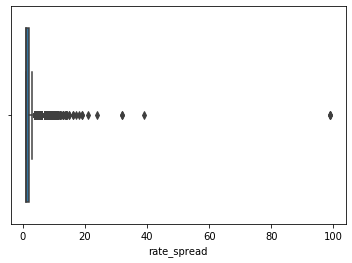

In [7]:
sns.boxplot(data.rate_spread)

From the boxplot and histogram, we can see that rate_spread values are dominantly in range from 0  to 20. Lets take a look at its quantile and decide whether we can remove some outlier to improve our model performance

In [8]:
data.rate_spread.quantile(0.99)

8.0

Rate spread range from 1 to 99 but most of the 99 percentile of data range from 1 to 8. We will remove any values > 8 to make our prediction more accurate.  

In [9]:
data.rate_spread[data.rate_spread> 8].count()

217

Only 140 out of 200000 values are greater than 9. It seems to be a small proportion so I will remove it without looking into it further. Will come back if the prediction model performs worse

Next, lets look at the correlation matrix between numeric columns and rate_spread

In [10]:
data = data[data.rate_spread  <= 8]
data.shape

(199783, 23)

Let's check rate_spread histogram after our clean-up

Text(0, 0.5, 'Frequency')

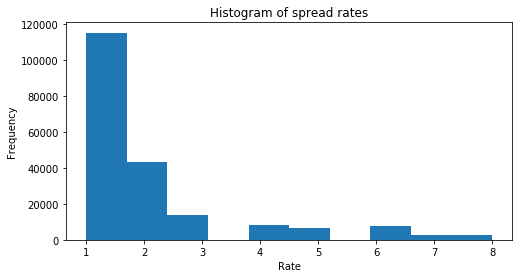

In [0]:
plt.figure(figsize = (8,4))
plt.hist(data.rate_spread)
plt.title('Histogram of spread rates')
plt.xlabel('Rate')
plt.ylabel('Frequency')

Looking better but spread_rate seem to heavily skewed. 
One option is to log-transform the target variable. 

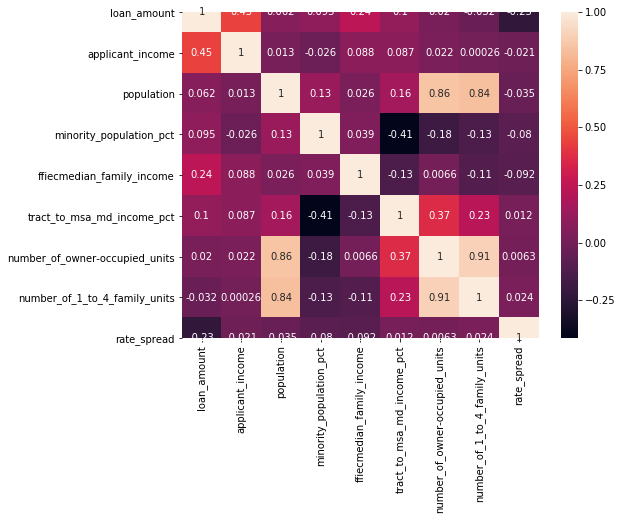

In [0]:
f = plt.figure(figsize = (8,6))
sns.heatmap(data.drop(['row_id'], axis = 1).corr(), annot = True)

<Figure size 432x432 with 0 Axes>

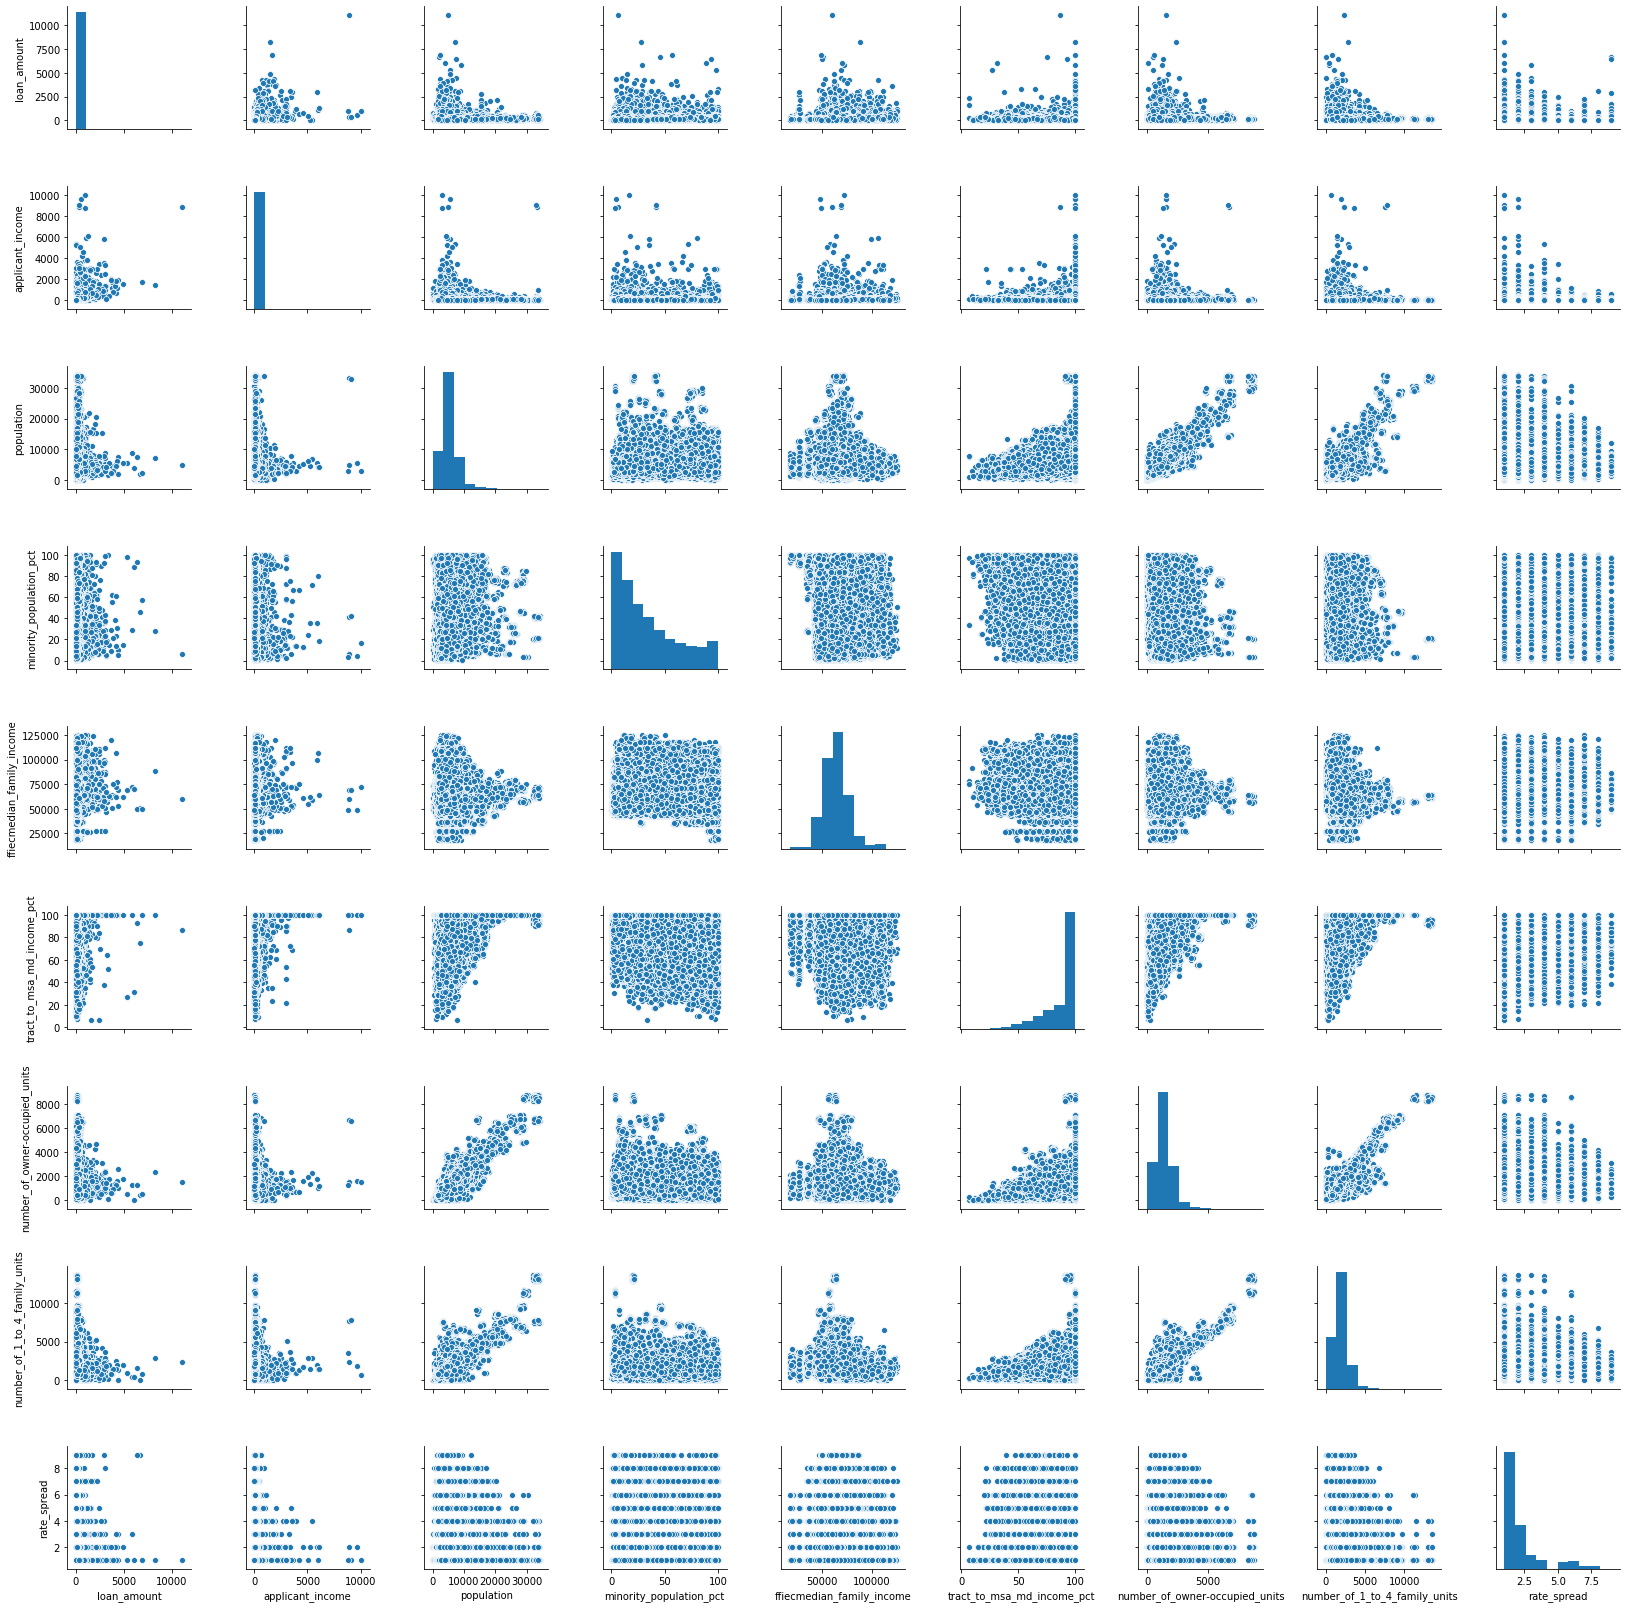

In [0]:
plt.figure(figsize  = (6,6))
sns.pairplot(data.select_dtypes(include = ['float64']))

From the correlation matrix and pair-wise scatterplot, we dont see any significant correlation betwwen any numeric variables and rate_spread. Might need to consider remove some of the feature later.

Now, lets check if there are any missing values in both numerical and categorical columns. Note that the missing values in categorical columns are encoded as -1 in this data 

In [11]:
# Check null value
for c in data.columns:
       print('Any Missing Values in ' + str(c) + ':' + str(data[c].isna().any()))

Any Missing Values in row_id:False
Any Missing Values in loan_type:False
Any Missing Values in property_type:False
Any Missing Values in loan_purpose:False
Any Missing Values in occupancy:False
Any Missing Values in loan_amount:False
Any Missing Values in preapproval:False
Any Missing Values in msa_md:False
Any Missing Values in state_code:False
Any Missing Values in county_code:False
Any Missing Values in applicant_ethnicity:False
Any Missing Values in applicant_race:False
Any Missing Values in applicant_sex:False
Any Missing Values in applicant_income:True
Any Missing Values in population:True
Any Missing Values in minority_population_pct:True
Any Missing Values in ffiecmedian_family_income:True
Any Missing Values in tract_to_msa_md_income_pct:True
Any Missing Values in number_of_owner-occupied_units:True
Any Missing Values in number_of_1_to_4_family_units:True
Any Missing Values in lender:False
Any Missing Values in co_applicant:False
Any Missing Values in rate_spread:False


In [12]:
for c in data.columns:
       print('Any Values = -1 in ' + str(c) + ': ' + str((data[c] == -1).any()))

Any Values = -1 in row_id: False
Any Values = -1 in loan_type: False
Any Values = -1 in property_type: False
Any Values = -1 in loan_purpose: False
Any Values = -1 in occupancy: False
Any Values = -1 in loan_amount: False
Any Values = -1 in preapproval: False
Any Values = -1 in msa_md: False
Any Values = -1 in state_code: True
Any Values = -1 in county_code: False
Any Values = -1 in applicant_ethnicity: False
Any Values = -1 in applicant_race: False
Any Values = -1 in applicant_sex: False
Any Values = -1 in applicant_income: False
Any Values = -1 in population: False
Any Values = -1 in minority_population_pct: False
Any Values = -1 in ffiecmedian_family_income: False
Any Values = -1 in tract_to_msa_md_income_pct: False
Any Values = -1 in number_of_owner-occupied_units: False
Any Values = -1 in number_of_1_to_4_family_units: False
Any Values = -1 in lender: False
Any Values = -1 in co_applicant: False
Any Values = -1 in rate_spread: False


Aside from loan_amount and rate_spread, other numerical columns all having columns. For the categorical variables, only state_code column have missing columns

In [13]:
for c in data.select_dtypes(exclude = ['category']): 
      print(str(c) + ':' + str(data[c].isna().sum()))

row_id:0
loan_amount:0
applicant_income:10671
population:1982
minority_population_pct:1982
ffiecmedian_family_income:1972
tract_to_msa_md_income_pct:2010
number_of_owner-occupied_units:1999
number_of_1_to_4_family_units:2003
rate_spread:0


We can see that around 1-5% of numeric values have missing values which are not really big. We can try to replace the missing values with 0 or average values

In [0]:
# 2 ways to impute the missing value to average values
for c in data.select_dtypes(exclude = ['category']):
    temp = data[data[c].notna()]
    data[c] = data[c].fillna(temp[c].median()) 

#imputer = SimpleImputer(strategy= 'median')
#data = imputer.fit_transform(data)

#for c in data.select_dtypes(exclude = ['category']):
#    data[c] = data[c].fillna(0) 

In [0]:
#data.state_code[data.state_code == -1].count()
#data = data[data.state_code != -1]
#data.shape

Next let's clean up our test data too

In [0]:
test_values = test_values.astype({'loan_type': 'category', 'property_type':'category', 'loan_purpose':'category', 
               'occupancy':'category', 'preapproval':'category', 'msa_md':'category', 'state_code':'category',
                'county_code':'category', 'applicant_ethnicity':'category', 'applicant_race':'category',
               'applicant_sex':'category', 'lender':'category', 'co_applicant':'category'})

In [17]:
for c in test_values.columns:
       print('Any Values = -1 in ' + str(c) + ': ' + str((data[c] == -1).any()))

Any Values = -1 in row_id: False
Any Values = -1 in loan_type: False
Any Values = -1 in property_type: False
Any Values = -1 in loan_purpose: False
Any Values = -1 in occupancy: False
Any Values = -1 in loan_amount: False
Any Values = -1 in preapproval: False
Any Values = -1 in msa_md: False
Any Values = -1 in state_code: True
Any Values = -1 in county_code: False
Any Values = -1 in applicant_ethnicity: False
Any Values = -1 in applicant_race: False
Any Values = -1 in applicant_sex: False
Any Values = -1 in applicant_income: False
Any Values = -1 in population: False
Any Values = -1 in minority_population_pct: False
Any Values = -1 in ffiecmedian_family_income: False
Any Values = -1 in tract_to_msa_md_income_pct: False
Any Values = -1 in number_of_owner-occupied_units: False
Any Values = -1 in number_of_1_to_4_family_units: False
Any Values = -1 in lender: False
Any Values = -1 in co_applicant: False


In [18]:
for c in test_values.columns: 
      print(str(c) + ':' + str(test_values[c].isna().sum()))

row_id:0
loan_type:0
property_type:0
loan_purpose:0
occupancy:0
loan_amount:0
preapproval:0
msa_md:0
state_code:0
county_code:0
applicant_ethnicity:0
applicant_race:0
applicant_sex:0
applicant_income:10371
population:1918
minority_population_pct:1920
ffiecmedian_family_income:1905
tract_to_msa_md_income_pct:1946
number_of_owner-occupied_units:1933
number_of_1_to_4_family_units:1933
lender:0
co_applicant:0


In [0]:
for c in test_values.select_dtypes(exclude = ['category']):
    temp = test_values[test_values[c].notna()]
    test_values[c] = test_values[c].fillna(temp[c].median()) 

#for c in test_values.select_dtypes(exclude = ['category']):
#  test_values[c] = test_values[c].fillna(0) 

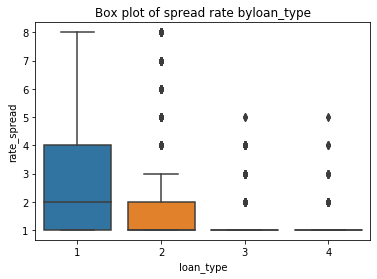

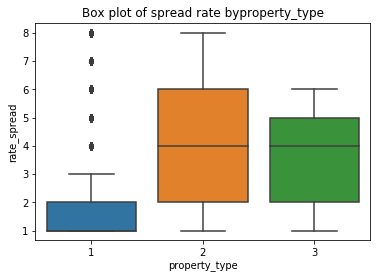

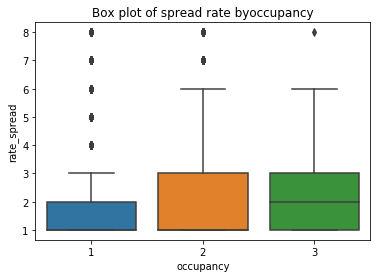

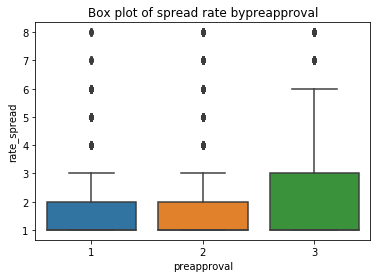

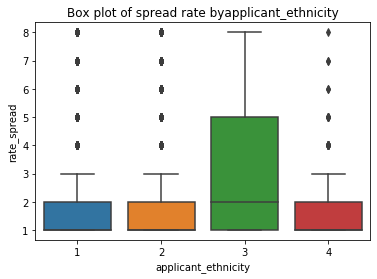

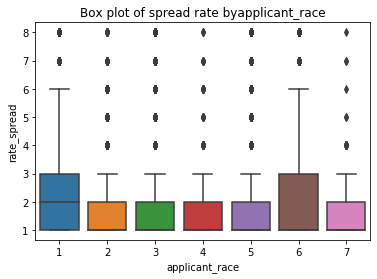

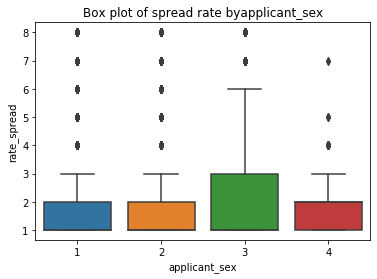

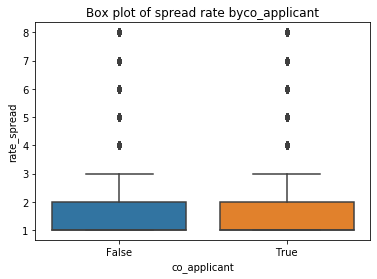

In [0]:
cat_col = ['loan_type', 'property_type', 'occupancy', 
           'preapproval', 'applicant_ethnicity','applicant_race', 
           'applicant_sex', 'co_applicant']
for col in cat_col:
  sns.boxplot(data[col], data['rate_spread'])
  plt.title('Box plot of spread rate by' + str(col))
  plt.show()

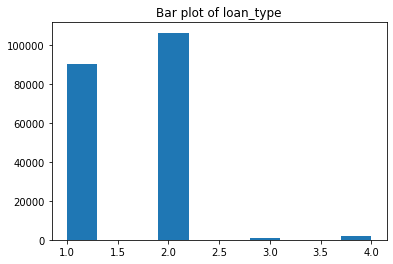

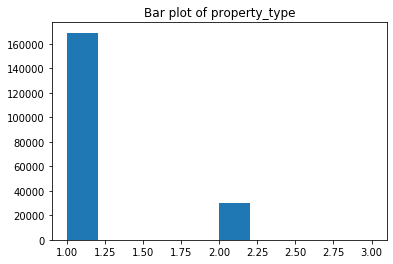

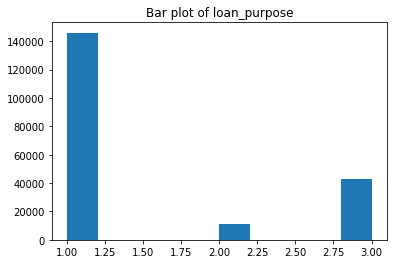

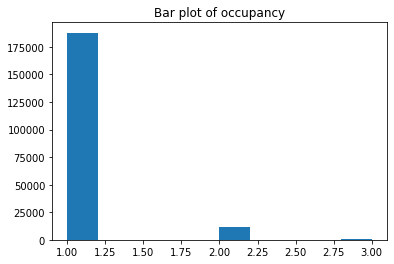

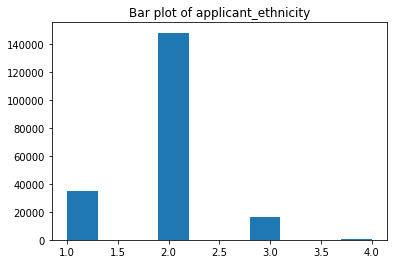

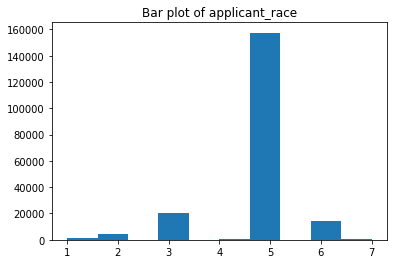

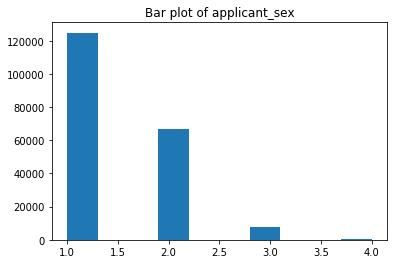

In [0]:
new_col = ['loan_type', 'property_type', 'loan_purpose', 'occupancy',
           'applicant_ethnicity','applicant_race', 
           'applicant_sex']
for col in new_col:
  plt.hist(data[col])
  plt.title('Bar plot of ' + str(col))
  plt.show()

In [0]:
# Derive new features

#data['med_rp_lender'] = 0 
#for i in data.lender.unique():
#  data['med_rp_lender'][data.lender == i] = data['rate_spread'][data.lender ==i].median()

#data['med_rp_state'] = 0 
#for i in data.state_code.unique():
#  data['med_rp_state'][data.state_code == i] = data['rate_spread'][data.state_code ==i].median()

#data['med_rp_msa'] = 0 
#for i in data.msa_md.unique():
#  data['med_rp_msa'][data.msa_md == i] = data['rate_spread'][data.msa_md ==i].median()
test_values['lti_rate'] = np.divide(test_values['loan_amount'],test_values['applicant_income'])
data['lti_rate'] = np.divide(data['loan_amount'],data['applicant_income'])


In [0]:
m = {"1": [1], "2": [2], "3": [3,4,5]}
m2 = {v:k for k,vv in m.items() for v in vv}
data.applicant_sex = data.applicant_sex.map(m2).astype("category", set(m2.values()))
test_values.applicant_sex = test_values.applicant_sex.map(m2).astype("category", set(m2.values()))


In [0]:
m = {"1": [1,4], "2": [2], "3": [3], '4':[6,7,8], '5':[5]}
m2 = {v:k for k,vv in m.items() for v in vv}
data.applicant_race = data.applicant_race.map(m2).astype("category", set(m2.values()))
test_values.applicant_race = test_values.applicant_race.map(m2).astype("category", set(m2.values()))


In [0]:
m = {"1": [1,4], "2": [2], "3": [3,4,5]}
m2 = {v:k for k,vv in m.items() for v in vv}
data.applicant_ethnicity = data.applicant_ethnicity.map(m2).astype("category", set(m2.values()))
test_values.applicant_ethnicity = test_values.applicant_ethnicity.map(m2).astype("category", set(m2.values()))


In [35]:
df = data.drop(['row_id'
                ], axis = 1)
df.columns

Index(['loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'rate_spread', 'lti_rate'],
      dtype='object')

In [0]:
test_set = test_values.drop(['row_id'
                ], axis = 1)

In [37]:
test_set[test_set.applicant_race == 7].count()

loan_type                         0
property_type                     0
loan_purpose                      0
occupancy                         0
loan_amount                       0
preapproval                       0
msa_md                            0
state_code                        0
county_code                       0
applicant_ethnicity               0
applicant_race                    0
applicant_sex                     0
applicant_income                  0
population                        0
minority_population_pct           0
ffiecmedian_family_income         0
tract_to_msa_md_income_pct        0
number_of_owner-occupied_units    0
number_of_1_to_4_family_units     0
lender                            0
co_applicant                      0
lti_rate                          0
dtype: int64

In [38]:
df.applicant_race

0         5
1         5
2         2
3         4
4         5
         ..
199995    5
199996    5
199997    5
199998    5
199999    5
Name: applicant_race, Length: 199783, dtype: category
Categories (5, object): [1, 2, 3, 4, 5]

In [0]:
cols_remain = ['lender','county_code']
cols_to_encode = ['loan_type', 'property_type', 'loan_purpose', 'co_applicant','applicant_ethnicity', 
                'applicant_race', 'applicant_sex', 'state_code', 'occupancy', 'preapproval', 'msa_md']
cols_to_scale = ['loan_amount',
       'applicant_income', 'population',
       'minority_population_pct', 'ffiecmedian_family_income',
       'tract_to_msa_md_income_pct', 'number_of_owner-occupied_units',
       'number_of_1_to_4_family_units', 'lti_rate']

In [0]:
Y = df.rate_spread
X = df.drop(['rate_spread'], axis = 1) 

In [0]:
for col in cols_to_scale:
  X[col] = np.log(X[col]+1)

In [0]:
for col in cols_to_scale:
  test_set[col] = np.log(test_set[col]+ 1)

In [0]:
#Y = np.log(Y)

In [0]:
Y.shape

(199783,)

In [0]:
#Y = pd.DataFrame(Y)

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.1, random_state = 42)

In [0]:
Y_train.shape

(179804,)

In [0]:
X_train.shape

(179804, 21)

In [0]:
test_set.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,1,2,1,1,46.0,3,262,37,83,1,5,2,50.0,10761.0,43.415,61732.0,100.000,2900.0,3603.0,1119,False
1,1,1,3,1,170.0,3,282,11,267,2,5,1,155.0,2285.0,20.115,50373.0,100.000,539.0,873.0,4216,False
2,1,1,1,1,174.0,3,274,12,162,1,5,1,102.0,7765.0,78.621,75175.0,54.165,1559.0,1712.0,2467,False
3,1,1,1,2,116.0,2,254,37,282,2,5,1,51.0,3387.0,96.208,48677.0,74.476,938.0,784.0,2773,True
4,1,1,3,1,108.0,3,194,41,17,2,5,1,88.0,3106.0,6.370,68070.0,100.000,1119.0,1301.0,3110,False


In [0]:
test_set.shape

(200000, 21)

In [0]:
scaler  = RobustScaler()
one_hot = OneHotEncoder(sparse = False, categories = 'auto')

In [45]:
scaler.fit(X_train[cols_to_scale]) 
one_hot.fit(X_train[cols_to_encode])

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=False)

In [0]:
train_scale_cols = scaler.transform(X_train[cols_to_scale])
train_oh_cols = one_hot.transform(X_train[cols_to_encode])
x_train = np.concatenate([X_train[cols_remain], train_scale_cols, train_oh_cols], axis = 1)

In [0]:
val_scale_cols = scaler.transform(X_val[cols_to_scale])
val_oh_cols = one_hot.transform(X_val[cols_to_encode])
x_val = np.concatenate([X_val[cols_remain], val_scale_cols, val_oh_cols], axis = 1)

test_scale_cols = scaler.transform(test_set[cols_to_scale])
test_oh_cols = one_hot.transform(test_set[cols_to_encode])
x_test = np.concatenate([test_set[cols_remain], test_scale_cols, test_oh_cols], axis = 1)

In [0]:
x_train[0]

array([2198, 324, -0.45535714285714285, 0.9069767441860465,
       0.8157894736842105, -0.2856848622158145, -0.5412796264256798,
       0.07455741421810952, 1.1867321867321867, 1.2879348630643968, 1.0,
       0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
      

In [0]:
def print_metrics(y_true, y_predicted):
    ## First compute R^2 and the adjusted R^2
    r2 = r2_score(y_true, y_predicted)    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(np.sqrt(mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(mean_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))

# Light GBM

In [0]:
np.random.seed(1)

In [0]:
?Ran

In [56]:
#lrs = [0.01,0.05,0.1,0.2,0.5]
#mcs = [40,60,80,100]
#md  = [11,12,15,20]
#leaves = [15,31,63,127,255]
#for l in lrs:
  model = LGBMRegressor(num_leaves = 63, n_estimators = 1000, min_child_samples = 40,
                        learning_rate = 0.1, random_state = 1)
#model = LGBMRegressor()
  model.fit(x_train, Y_train)
  Y_train_pred = model.predict(x_train)
#scores = cross_val_score(model, X_train, Y_train, cv = 5, sc)
  Y_val_pred = model.predict(x_val)
  print('Training set score: \n')
  print_metrics(Y_train, Y_train_pred)
  print('\n Validation set score: \n')
  #print_metrics(Y_val, Y_val_pred)
  print_metrics(Y_val, Y_val_pred)


Training set score: 

Mean Square Error      = 0.35850467213335196
Root Mean Square Error = 0.5987525967654354
Mean Absolute Error    = 0.42244937215792416
R^2                    = 0.8568999856292553

 Validation set score: 

Mean Square Error      = 0.561733734627728
Root Mean Square Error = 0.7494889823257764
Mean Absolute Error    = 0.5160876551413469
R^2                    = 0.7731198774354737


In [0]:
Y_test_pred = model.predict(x_test)


In [0]:
Y_test_pred

array([6., 2., 2., ..., 1., 1., 1.])

In [0]:
res = pd.DataFrame({'row_id': test_values.row_id, 'rate_spread': Y_test_pred})

In [0]:
res.head(5)

,row_id,rate_spread
0,0,5.562004
1,1,2.118970
2,2,1.562220
3,3,1.793223
4,4,1.537191


In [0]:
res.to_csv('/content/drive/My Drive/Projects & Stuffs/Spread Rate/gudlife.csv', index  = False)